## Import library and datasets

In [52]:
from sklearn.datasets import fetch_20newsgroups

import numpy as np
np.random.seed(42)
import random
random.seed(42)

import matplotlib as mpl
mpl.use('pgf')

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors


In [53]:
categories = None
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None)


##  Plot a histogram of documents for each of twenty categories to check if they are evenly distributed.

In [54]:
np.unique(twenty_train.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

Text(0, 0.5, 'Number of Documents')

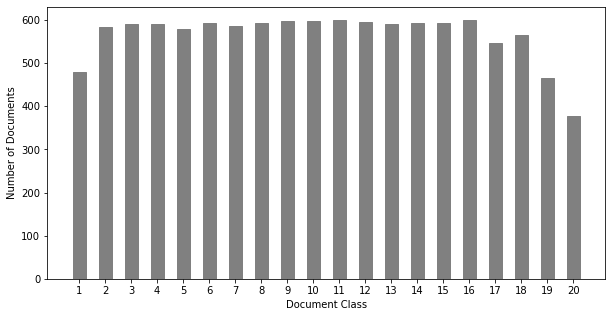

In [55]:
from collections import Counter
c = Counter(twenty_train.target)
bar_heights = [c[i] for i in range(20)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

x = range(1,21)
bars = ax.bar(x, bar_heights, width = 0.5, color='0.5', edgecolor='0.5')

ax.set_xticks([i for i in x])

ax.set_xlabel("Document Class")
ax.set_ylabel("Number of Documents")



In [56]:
for i in range(20):
    print("{}: {}".format(i+1, twenty_train.target_names[i]))

1: alt.atheism
2: comp.graphics
3: comp.os.ms-windows.misc
4: comp.sys.ibm.pc.hardware
5: comp.sys.mac.hardware
6: comp.windows.x
7: misc.forsale
8: rec.autos
9: rec.motorcycles
10: rec.sport.baseball
11: rec.sport.hockey
12: sci.crypt
13: sci.electronics
14: sci.med
15: sci.space
16: soc.religion.christian
17: talk.politics.guns
18: talk.politics.mideast
19: talk.politics.misc
20: talk.religion.misc


## Do binary classification to distinguish computer technology and recreational activities

In [57]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
             'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

### Extract Feature by Constructing TF-IDF matrices

In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# set min document frequency 3, stop word 'english'

min_df = 3
count_vect = CountVectorizer(min_df=min_df, stop_words='english')
count_vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [59]:
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)

In [60]:
X_train_counts.toarray().shape

(4732, 20297)

In [61]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train_counts)
X_test = tfidf.transform(X_test_counts)
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (4732, 20297)
X_test.shape: (3150, 20297)


In [62]:
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))

from string import punctuation
print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
print("# of combined_stopwords:\t %s" % len(combined_stopwords))

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32
# of combined_stopwords:	 410


In [63]:
import nltk
from nltk import pos_tag

In [64]:
# Define functions to
# Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
# remove numbers

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

# handles preprocessing, tokenization and n-grams generation
analyzer = CountVectorizer().build_analyzer()

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

In [65]:
min_df = 3
count_vect = CountVectorizer(min_df=min_df,analyzer=stem_rmv_punc, stop_words='english')

In [66]:
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)

In [67]:
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

X_train.shape: (4732, 20297)
X_test.shape: (3150, 20297)


### Dimensionality Reduction on TF-idf matrix since it is sparse and low rank 

In [68]:
# Experiment both Latent Semantic indexing and Nonnegative matrix factorization

from sklearn.decomposition import NMF, TruncatedSVD
n_components = 50
nmf = NMF(n_components=n_components)
svd = TruncatedSVD(n_components=n_components)

X_train_nmf = nmf.fit_transform(X_train)
X_test_nmf = nmf.transform(X_test)

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

In [69]:
np.shape(svd.components_)

(50, 20297)

In [70]:
# Compare error between original data and reconstruction from low dimension representation
error_svd = np.square(X_train - X_train_svd.dot(svd.components_)).sum()
error_nmf = np.square(X_train - X_train_nmf.dot(nmf.components_)).sum()
print(f'error_svd: {error_svd}, sqrt: {np.sqrt(error_svd)}')
print(f'error_nmf: {error_nmf}, sqrt: {np.sqrt(error_nmf)}')

error_svd: 4171.536343841766, sqrt: 64.58743177926931
error_nmf: 4201.036854689368, sqrt: 64.81540599802926


## Classification Algorithm

In [71]:
label = twenty_train.target > 3
label_test = twenty_test.target > 3

In [72]:
from sklearn.svm import LinearSVC, SVC

soft_svm = SVC(C=0.01, kernel='linear')
hard_svm = SVC(C=1000, kernel='linear')

In [73]:
soft_svm.fit(X_train_svd, label)
hard_svm.fit(X_train_svd, label)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [24]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
#from sklearn.metrics import plot_confusion_matrix

In [35]:
# function that calculate needed metrics for all kinds of classifiers used in this notebook
def clfMetrics(clf, test_data_x, test_data_y):
   

    y_predicted = clf.predict(test_data_x)

    accu = np.mean(y_predicted == test_data_y)
    cm = confusion_matrix(test_data_y, y_predicted)

    
    if type(clf) in {SVC, LinearSVC, OneVsRestClassifier, OneVsOneClassifier, LogisticRegression}:
        y_scores = clf.decision_function(test_data_x)
    elif type(clf) in GaussianNB:
        y_scores = clf.predict_proba(test_data_x)
    
    fpr_list = []
    tpr_list = []
    
    precisions = []
    recalls = []

    labels = np.unique(np.concatenate((test_data_y, y_predicted)))
    if len(labels) <= 2:
        precs = precision_score(test_data_y, y_predicted)
        recal = recall_score(test_data_y, y_predicted)
        precisions.append(precs)
        recalls.append(recal)
        precision = precs
        recall = recal
    else:
        for i in labels:
            precs = precision_score(test_data_y, y_predicted, labels=[i], average='micro')
            recal = recall_score(test_data_y, y_predicted, labels=[i], average='micro')
            precisions.append(precs)
            recalls.append(recal)
        precision = precision_score(test_data_y, y_predicted, average='micro')
        recall = recall_score(test_data_y, y_predicted, average='micro')

    if len(y_scores.shape) < 2:
        fpr, tpr, _ = roc_curve(test_data_y,y_scores)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    else:
        i = 0
        for score in y_scores.T:
            fpr, tpr, _ = roc_curve(test_data_y, score, pos_label=i)
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            i += 1
    
    print("Accuracy:\t" + str(accu))
    print("Confusion Matrix:")
    print(cm)
    print("Precision:")
    print(precisions)
    print(precision)
    print("Recall:")
    print(recalls)
    print(recall)
    print("F1 Score:")
    print(2 / (1/np.array(precisions) + 1/np.array(recalls)))
    return {'cm': cm, 'fpr_list': fpr_list, 'tpr_list': tpr_list, 'precisions': precisions, 'recalls': recalls}


# The function that plots ROC curves, works for multiclass classification
def plotROC(fpr_list, tpr_list, classnames):
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from cycler import cycler
    %matplotlib inline
    from sklearn.metrics import auc
    
    lw = 2

    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)


    for fpr, tpr, cname in zip(fpr_list, tpr_list, classnames):
        roc_auc = auc(fpr,tpr)
        ax.plot(fpr, tpr, lw=lw, label= cname + ' area under curve = %0.4f' % roc_auc)
    # ax.plot((0,0),(0,1.05),'k--')
    
    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    plt.ioff()
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          filename=None,
                          size=None):
    """
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, ha='right', rotation=20)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, "{:d}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(12)
    plt.tight_layout()
    plt.ioff()


### Support Vector machines

Accuracy:	0.5053968253968254
Confusion Matrix:
[[   2 1558]
 [   0 1590]]
Precision:
[0.5050825921219823]
0.5050825921219823
Recall:
[1.0]
1.0
F1 Score:
[0.67116927]
Confusion matrix, without normalization
[[1505   55]
 [  40 1550]]


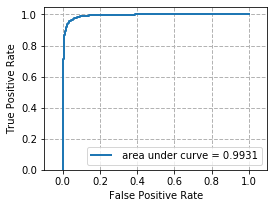

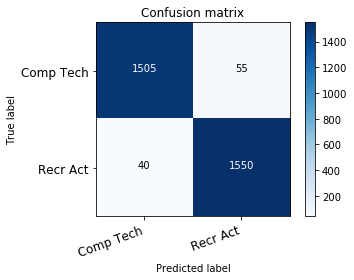

In [36]:
soft_svm_metrics = clfMetrics(soft_svm, X_test_svd, label_test)
plotROC(soft_svm_metrics['fpr_list'], soft_svm_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(hard_svm_metrics['cm'],classnames)

Accuracy:	0.969841269841
Confusion Matrix:
[[1505   55]
 [  40 1550]]
Precision:
[0.96573208722741433]
0.965732087227
Recall:
[0.97484276729559749]
0.974842767296
F1 Score:
[ 0.97026604]
Confusion matrix, without normalization
[[1505   55]
 [  40 1550]]


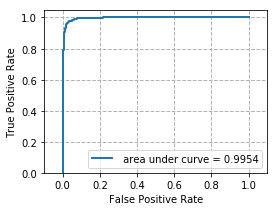

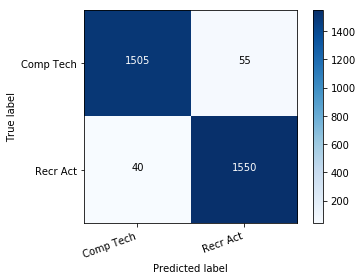

In [94]:
hard_svm_metrics = clfMetrics(hard_svm, X_test_svd, label_test)
plotROC(hard_svm_metrics['fpr_list'], hard_svm_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(hard_svm_metrics['cm'],classnames)

In [44]:
#  grid search for best regularization coefficient using five-fold cross validation average accuracy
from sklearn.model_selection import GridSearchCV

param_grid = {
        'C': 10.0 ** np.arange(-3,4),
    }

# reducer_labels = ['LinearSVC', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(SVC(kernel='linear'), cv=5, n_jobs=4, param_grid=param_grid, scoring='accuracy')
grid.fit(X_train_svd, label)
best_svm = grid.best_estimator_

print(f'Best C for SVC(kernel="linear"): {grid.best_params_}, avg score: {grid.best_score_}')

Best C for SVC(kernel="linear"): {'C': 10.0}, avg score: 0.8915896462935358


Accuracy:	0.8792332268370607
Confusion Matrix:
[[319  48  25   0]
 [ 37 323  24   1]
 [ 24  18 346   2]
 [  6   1   3 388]]
Precision:
[0.8264248704663213, 0.8282051282051283, 0.8693467336683417, 0.9923273657289002]
0.8792332268370607
Recall:
[0.8137755102040817, 0.8389610389610389, 0.8871794871794871, 0.9748743718592965]
0.8792332268370607
F1 Score:
[0.82005141 0.83354839 0.87817259 0.98352345]
Confusion matrix, without normalization
[[319  48  25   0]
 [ 37 323  24   1]
 [ 24  18 346   2]
 [  6   1   3 388]]


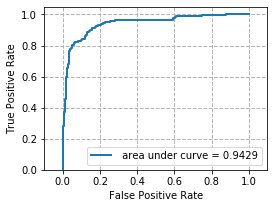

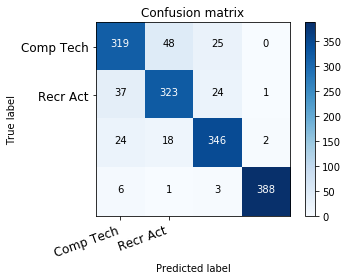

In [45]:

best_svm_metrics = clfMetrics(best_svm, X_test_svd, label_test)
plotROC(best_svm_metrics['fpr_list'], best_svm_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(best_svm_metrics['cm'],classnames)

### Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression
lgr_plain = LogisticRegression(C=10**6)

lgr_plain.fit(X_train_svd, label)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:	0.968888888889
Confusion Matrix:
[[1497   63]
 [  35 1555]]
Precision:
[0.96106304079110016]
0.961063040791
Recall:
[0.9779874213836478]
0.977987421384
F1 Score:
[ 0.96945137]
Confusion matrix, without normalization
[[1497   63]
 [  35 1555]]


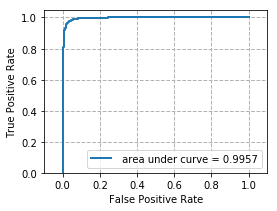

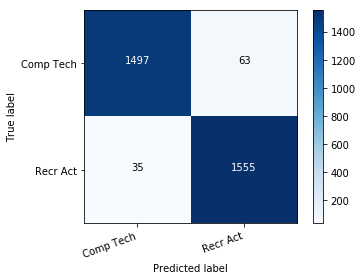

In [98]:
lgr_metrics = clfMetrics(lgr_plain, X_test_svd, label_test)
plotROC(lgr_metrics['fpr_list'], lgr_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(lgr_metrics['cm'],classnames)

Best C for l1 is {'C': 10.0}, the average score is 0.9754861797910838
Accuracy:	0.9682539682539683
Confusion Matrix:
[[1496   64]
 [  36 1554]]
Precision:
[0.9604449938195303]
0.9604449938195303
Recall:
[0.9773584905660377]
0.9773584905660377
F1 Score:
[0.96882793]
Confusion matrix, without normalization
[[1496   64]
 [  36 1554]]


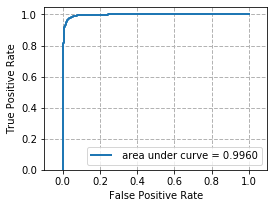

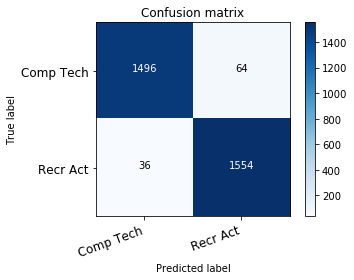

In [76]:
from sklearn.model_selection import GridSearchCV
param_grid = {
        'C': 10.0 ** np.arange(-3,4),
}
best_lgrs = {}
# for regularization_type in ['l1', 'l2']:
regularization_type = 'l1'
lgr = LogisticRegression(penalty = regularization_type,solver='liblinear' )
grid = GridSearchCV(lgr, cv=5, n_jobs=4, param_grid=param_grid, scoring='accuracy')
grid.fit(X_train_svd, label)
print(f'Best C for {regularization_type} is {grid.best_params_}, the average score is {grid.best_score_}')
best_lgrs[regularization_type] = grid.best_estimator_
lgr_metrics = clfMetrics(grid.best_estimator_, X_test_svd, label_test)
plotROC(lgr_metrics['fpr_list'], lgr_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(lgr_metrics['cm'],classnames)


Best C for l2 is {'C': 100.0}, the average score is 0.9767537857393215
Accuracy:	0.9692063492063492
Confusion Matrix:
[[1499   61]
 [  36 1554]]
Precision:
[0.9622291021671827]
0.9622291021671827
Recall:
[0.9773584905660377]
0.9773584905660377
F1 Score:
[0.96973479]
Confusion matrix, without normalization
[[1499   61]
 [  36 1554]]


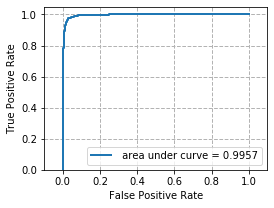

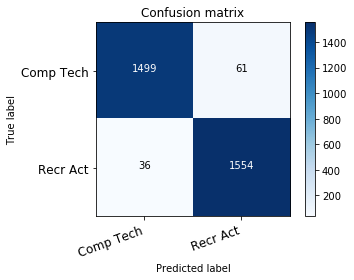

In [77]:
regularization_type = 'l2'
lgr = LogisticRegression(penalty = regularization_type)
grid = GridSearchCV(lgr, cv=5, n_jobs=4, param_grid=param_grid, scoring='accuracy')
grid.fit(X_train_svd, label)
print(f'Best C for {regularization_type} is {grid.best_params_}, the average score is {grid.best_score_}')
best_lgrs[regularization_type] = grid.best_estimator_
lgr_metrics = clfMetrics(grid.best_estimator_, X_test_svd, label_test)
plotROC(lgr_metrics['fpr_list'], lgr_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(lgr_metrics['cm'],classnames)


In [101]:
lgr_plain.coef_

array([[ -17.51537026,  153.81135434,    0.20099626,   82.33073892,
          38.90628539,  -49.3499197 ,  -20.349852  ,   10.16023807,
          12.73591995,   -5.66340544,    4.99041075,   16.09415314,
         -17.672968  ,    2.80516894,   -7.28632215,  -12.33179226,
          12.72170593,   -5.28587718,    5.65785422,   13.59198275,
          -7.14953032,   -5.65155074,    9.04841437,   25.9482631 ,
          -3.66413785,   -0.15997399,    5.82211457,   -9.33681288,
          -0.74473654,    0.40093494,   -5.69710389,    7.79104918,
           6.9893361 ,   31.45841955,    9.1432369 ,   11.65631105,
          -9.00884423,    7.28636112,  -13.12579603,  -13.08928905,
          -4.87965082,   -8.16230472,  -14.70620791,    3.11198882,
           3.75772101,   12.69348323,   -4.76965296,   -0.30339963,
           6.86752982,    0.16536996]])

In [102]:
best_lgrs['l1'].coef_

array([[ -1.32438001e+01,   1.32385333e+02,   0.00000000e+00,
          6.68515359e+01,   2.90415799e+01,  -3.66676187e+01,
         -1.55336016e+01,   7.97675547e+00,   9.88214907e+00,
         -3.43052021e+00,   1.64673663e+00,   1.22470830e+01,
         -1.25394485e+01,   1.87097588e+00,  -7.08713990e+00,
         -7.22836053e+00,   9.06469855e+00,  -3.10688447e+00,
          0.00000000e+00,   5.61992708e+00,  -2.52505085e+00,
         -3.16555092e+00,   8.54714961e+00,   2.26821351e+01,
         -8.25026393e-01,   0.00000000e+00,   4.90905315e-02,
         -8.39183229e+00,   0.00000000e+00,   0.00000000e+00,
         -2.79570847e+00,   6.18623876e+00,   5.33514940e+00,
          2.33183822e+01,   6.21467046e+00,   8.91826143e+00,
         -7.15355143e+00,   3.26528715e+00,  -7.52821435e+00,
         -9.43101134e+00,  -2.78744498e+00,  -4.84403708e+00,
         -1.03233226e+01,   5.49773078e-01,   1.45013706e+00,
          9.95233376e+00,  -1.48362138e+00,   3.60153155e-01,
        

In [103]:
best_lgrs['l2'].coef_

array([[ -7.83127385,  96.70035153,   2.8891493 ,  49.8825654 ,
         21.26116019, -23.75082455, -12.37528347,   7.43851173,
          9.73033113,  -7.42459628,   8.75546685,  11.99037155,
        -12.70785976,   6.61049892,  -7.65050286,  -7.73336738,
          7.27952606,  -3.86569409,   3.92675666,   7.11259194,
         -4.28693491,  -2.54154651,   7.47706775,  15.31728312,
          0.18710825,  -2.53404073,   0.19367776,  -7.93061664,
         -1.77860417,   0.76497861,  -3.58971692,   5.3175203 ,
          3.02772759,  16.28934471,   5.41758857,   5.79329542,
         -6.87542784,   3.74779113,  -5.17358944,  -6.74568056,
         -3.35457751,  -3.27267427,  -8.50326131,   1.27415635,
          1.99888429,   7.2205096 ,  -1.36878784,   1.50220846,
          4.07585266,   1.87189701]])

### Gaussian Naive Bayes

In [104]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_svd, label)


GaussianNB(priors=None)

Accuracy:	0.906666666667
Confusion Matrix:
[[1361  199]
 [  95 1495]]
Precision:
[0.88252656434474619]
0.882526564345
Recall:
[0.94025157232704404]
0.940251572327
F1 Score:
[ 0.91047503]
Confusion matrix, without normalization
[[1361  199]
 [  95 1495]]


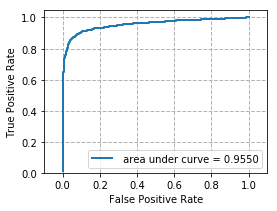

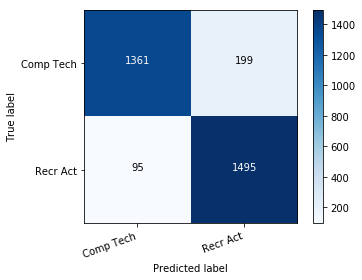

In [105]:
gnb_metrics = clfMetrics(gnb, X_test_svd, label_test)
plotROC(gnb_metrics['fpr_list'], gnb_metrics['tpr_list'], [''])
classnames = ['Comp Tech', 'Recr Act']
plot_confusion_matrix(gnb_metrics['cm'],classnames)

## Data pipeline to select best combination of feature extraction, dim reduction and classification algorithm

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory

import pandas as pd

results = {}
for remove in [('headers', 'footers'), ()]:
    train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=None, remove=remove)
#     test_data  =  fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=None, remove=remove)
    label = train_data.target > 3
#     label_test = test_data.target > 3

    cachedir = mkdtemp()
    memory = Memory(cachedir=cachedir, verbose=0)

    pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=1, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(random_state=0)),
        ('clf', GaussianNB()),
    ],
    memory=memory
    )

#     N_FEATURES_OPTIONS = [10, 50]
#     C_OPTIONS = [0.1, 1, 10]
#     REG_OPTIONS = ['l1', 'l2']
#     REG_STRENGTH_OPTIONS = [0.1, 1, 10]
    

    param_grid = {
            'vect__min_df': [3, 5],
            'vect__analyzer': ['word', stem_rmv_punc],
            'reduce_dim': [TruncatedSVD(n_components=50), NMF(n_components=50)],
            'clf': [best_svm] + list(best_lgrs.values()) + [GaussianNB()],
    }
#         {
#             'reduce_dim': [TruncatedSVD(), NMF()],
#             'reduce_dim__n_components': N_FEATURES_OPTIONS,
#             'clf': [GaussianNB()],
#             'clf__C': C_OPTIONS
#         },
    
    # reducer_labels = ['LinearSVC', 'NMF', 'KBest(chi2)']

    grid = GridSearchCV(pipeline, cv=5, n_jobs=4, param_grid=param_grid, scoring='accuracy')
    grid.fit(train_data.data, label)
    rmtree(cachedir)
    results[str(remove)] = pd.DataFrame(grid.cv_results_)

In [ ]:
import pickle

from os import path
grid_pkl_file = 'grid_result.pkl'
if not path.isfile(grid_pkl_file):
    with open(grid_pkl_file, 'wb') as f:
        pickle.dump(results, f)
else:
    with open(grid_pkl_file, 'rb') as f:
        results = pickle.load(f)
        
results.keys()
sorted_df = pd.concat([results["('headers', 'footers')"], results['()']]).sort_values('mean_test_score', ascending=False)
sorted_df
sorted_df.head(1).params.values[0]

## Multiclass classification

In [38]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import preprocessing

categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale','soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)


X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)

tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train_counts)
X_test = tfidf.transform(X_test_counts)
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')


X_train_nmf = nmf.fit_transform(X_train)
X_test_nmf = nmf.transform(X_test)

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

label = twenty_train.target
label_test = twenty_test.target

X_train.shape: (2352, 8396)
X_test.shape: (1565, 8396)


Accuracy:	0.773162939297
Confusion Matrix:
[[304  26  59   3]
 [107 204  65   9]
 [ 57   8 310  15]
 [  1   0   5 392]]
Precision:
[0.64818763326226014, 0.8571428571428571, 0.70615034168564916, 0.93556085918854415]
0.773162939297
Recall:
[0.77551020408163263, 0.52987012987012982, 0.79487179487179482, 0.98492462311557794]
0.773162939297
F1 Score:
[ 0.70615563  0.65489567  0.74788902  0.95960832]
Confusion matrix, without normalization
[[304  26  59   3]
 [107 204  65   9]
 [ 57   8 310  15]
 [  1   0   5 392]]


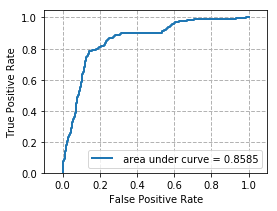

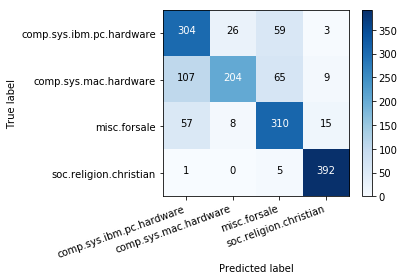

In [113]:
from sklearn.naive_bayes import MultinomialNB

OneVsOneNB = OneVsOneClassifier(MultinomialNB())
OneVsOneNB.fit(X_train_nmf, label)

OneVsOneNB_metrics = clfMetrics(OneVsOneNB, X_test_nmf, label_test)
plotROC(OneVsOneNB_metrics['fpr_list'], OneVsOneNB_metrics['tpr_list'], [''])
plot_confusion_matrix(OneVsOneNB_metrics['cm'],categories)



Accuracy:	0.895207667732
Confusion Matrix:
[[339  34  19   0]
 [ 28 339  18   0]
 [ 35  20 334   1]
 [  5   1   3 389]]
Precision:
[0.83292383292383287, 0.86040609137055835, 0.89304812834224601, 0.99743589743589745]
0.895207667732
Recall:
[0.86479591836734693, 0.88051948051948048, 0.85641025641025637, 0.97738693467336679]
0.895207667732
F1 Score:
[ 0.8485607   0.8703466   0.87434555  0.98730964]
Confusion matrix, without normalization
[[339  34  19   0]
 [ 28 339  18   0]
 [ 35  20 334   1]
 [  5   1   3 389]]


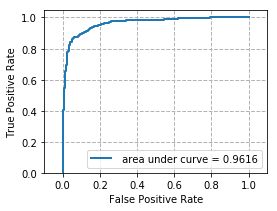

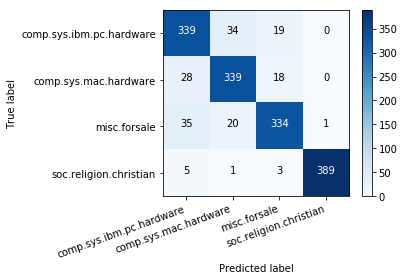

In [114]:
OneVsOneNB = OneVsOneClassifier(MultinomialNB())
OneVsOneNB.fit(X_train, label)

OneVsOneNB_metrics = clfMetrics(OneVsOneNB, X_test, label_test)
plotROC(OneVsOneNB_metrics['fpr_list'], OneVsOneNB_metrics['tpr_list'], [''])
plot_confusion_matrix(OneVsOneNB_metrics['cm'],categories)


Accuracy:	0.912460063898
Confusion Matrix:
[[355  20  17   0]
 [ 32 333  20   0]
 [ 21  14 354   1]
 [  9   0   3 386]]
Precision:
[0.85131894484412474, 0.9073569482288828, 0.89847715736040612, 0.99741602067183466]
0.912460063898
Recall:
[0.90561224489795922, 0.86493506493506489, 0.90769230769230769, 0.96984924623115576]
0.912460063898
F1 Score:
[ 0.8776267   0.8856383   0.90306122  0.98343949]
Confusion matrix, without normalization
[[355  20  17   0]
 [ 32 333  20   0]
 [ 21  14 354   1]
 [  9   0   3 386]]


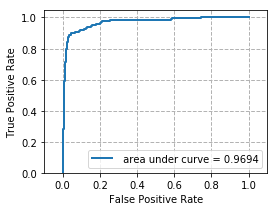

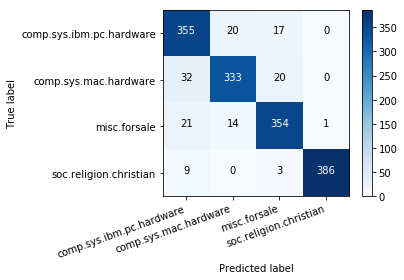

In [115]:
OneVsOneSVM = SVC(kernel ='linear', max_iter=-1, probability=True)

OneVsOneSVM.fit(X_train, label)

OneVsOneSVM_metrics = clfMetrics(OneVsOneSVM, X_test, label_test)
plotROC(OneVsOneSVM_metrics['fpr_list'], OneVsOneSVM_metrics['tpr_list'], [''])
plot_confusion_matrix(OneVsOneSVM_metrics['cm'],categories)


In [152]:
lb=preprocessing.LabelBinarizer()
lb.fit([0,1,2,3])
label=lb.transform(label)
label_test= lb.transform(label_test)
np.shape(label)

(2352, 4)

In [39]:
label = twenty_train.target
label_test = twenty_test.target

In [40]:
OneVsRestSVM = OneVsRestClassifier(SVC(kernel ='linear', max_iter=-1, probability=True))
OneVsRestSVM.fit(X_train, label)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

Accuracy:	0.9118210862619809
Confusion Matrix:
[[347  23  21   1]
 [ 29 336  18   2]
 [ 19  15 355   1]
 [  5   0   4 389]]
Precision:
[0.8675, 0.8983957219251337, 0.8919597989949749, 0.989821882951654]
0.9118210862619809
Recall:
[0.8852040816326531, 0.8727272727272727, 0.9102564102564102, 0.9773869346733668]
0.9118210862619809
F1 Score:
[0.87626263 0.88537549 0.90101523 0.98356511]
Confusion matrix, without normalization
[[347  23  21   1]
 [ 29 336  18   2]
 [ 19  15 355   1]
 [  5   0   4 389]]


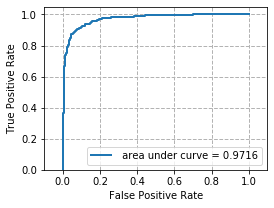

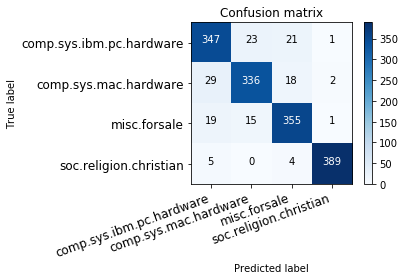

In [42]:
OneVsRestSVM_metrics = clfMetrics(OneVsRestSVM, X_test, label_test)
plotROC(OneVsRestSVM_metrics['fpr_list'], OneVsRestSVM_metrics['tpr_list'], [''])
plot_confusion_matrix(OneVsRestSVM_metrics['cm'],categories)
